Plot rocky lost and calculate some stats

In [67]:
# from BZ import *
import xarray as xr
import rioxarray as xrr
from shapely.geometry import box

import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
import seaborn as sns

from shared import *

%matplotlib inline
%pdb off
    
print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-09-04 16:27:15.606027


# Setup

In [68]:
habit = 'rocky'
scen0   = 'Low2050'
region0 = 'South'
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
use_s2  = False
use_vlm = True

In [69]:
habits = 'rocky beach'.split()
scens = 'Low IntLow Int IntHigh High'.split()
years = '2050 2100'.split()

## Constants
- Shouldnt have to change below here

In [70]:
path_res = path_wd / 'results'
regions = 'South Central North'.split()
scen = scen0.replace('_rsl', '')
s2_ext = '_s2' if use_s2 else ''
vlm_ext = '_vlm' if use_vlm else ''

basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')
# basemap   = cimgt.GoogleTiles(url='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'))

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo
            
projp = ccrs.PlateCarree()
GFS = GS  = 14 
TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels

pt_parms  = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}

sty_cari   = dict(facecolor='none', edgecolor='deeppink') 

In [71]:
path_dems = path_wd / 'dems'
path_dems_all  = path_dems / 'all' # symlinked with everything

path_north   = path_dems / 'CA_north_coned_DEM_2020_9181'
gdf_north    = gpd.read_file(path_north / 'tileindex_CA_north_coned_DEM_2020.shp').to_crs(4326)

path_central = path_dems / 'CA_Central_CoNED_DEM_2017_8657'
gdf_central  = gpd.read_file(path_central / 'ca2017_central_coned_m8657.kmz').to_crs(4326)

path_south   = path_dems / 'CA_Southern_CoNED_DEM_2016_8658/'
gdf_south    = gpd.read_file(path_south / 'socal.kmz').to_crs(4326)

dct_gdf_bounds = {'South': gdf_south, 'Central': gdf_central, 'North': gdf_north}

In [72]:
# load the results associated with this polygon
BObj = CARIRegion(region0, path_wd, use_s2)
gdf_rocky_coned = BObj.get_cari('rocky')
gdf_rocky_coned['poly_id'] = gdf_rocky_coned.index
gdf_rocky_wgs = gdf_rocky_coned.to_crs(4326)

# gdf_enso_map = get_enso_map(BObj_north.path_enso_dems, BObj_north.epsg) # enso dem path and its bounds

## Helper Functions

In [73]:
# diff than last because of negative
def cut_polys(df_all_in, gdf_cari_in, pct_lost_min=-100, area_min=0):
    """ Input for plot_bars """
    lst_poly_area = [] # for plotting hist and excluding outliers
    polys_to_drop = []
    for poly_ix, df_poly in df_all_in.groupby('poly_ix'):
        pct_lost  = (100 * df_poly[f'{scen}_MLLW'].mean())
        cari_poly = gdf_cari_in.loc[[poly_ix]]
        cari_area = cari_poly.area.item() # m2
        if (pct_lost < pct_lost_min) | (cari_area < area_min):
            polys_to_drop.append(poly_ix)
        lst_poly_area.append(cari_area) 
        # if np.isnan(cari_area):
        #     print (poly_ix)

    n_polys = df_all_in.groupby('poly_ix').count().shape[0]
    n_pct = 100 * len(polys_to_drop) / n_polys
    print (f'Dropping {len(polys_to_drop)} of {n_polys} polygons ({n_pct:.2f}%)')
    ## good; get rid of slivers
    df_all_new = df_all_in[~df_all_in.poly_ix.isin(polys_to_drop)]
    ser_pcts_new = {}
    for reg, df_reg in df_all_new.groupby('region'):
        ser_pcts_new[reg] = 100*(df_reg[f'{scen}_MLLW'].mean())
    
    ser_pcts_new['Total'] = 100*df_all_new[f'{scen}_MLLW'].mean()
    ser_pcts_new = pd.Series(ser_pcts_new)
    return df_all_new, ser_pcts_new, lst_poly_area


# beaches only
def plot_bars(ser_pcts_in):
    ser_pcts_in.index = ser_pcts_in.index.map(lambda x: x.rstrip(f'_{k}'))
    try:
        ser_pcts_in = ser_pcts_in.loc['South Central North Total'.split()]
    except:
        print ('Couldnt sort by regions')
    fig, axes = plt.subplots(figsize=(12, 6))
    sns.barplot(data=ser_pcts_in, ax=axes, color='dimgray')
    axes.set_ylabel('Beaches Lost (%)', fontsize=YFS)
    axes.set_xlabel('Region', fontsize=XFS)
    axes.tick_params(axis='both', labelsize=XFS-4)  
    axes.bar_label(axes.containers[0], fmt="{:.1f}%".format, fontsize=XFS-4);
    axes.grid(color='k', linestyle='--', alpha=0.1)
    return fig, axes


# Check A Single Region / Scenario
- a '1' in the MLLW column means lost due to MLLW > Land
- a '1' in the MAH column means lost due to MAH
- a '-1' in the MAH column means gained

**The indexes are for South Rocky Low2050**

In [42]:
src0 = path_res / f'{region0}_{habit}_{scen0}{s2_ext}{vlm_ext}.csv'
assert src0.exists(), f'Concatenate the {habit} with make_rocky_beach.concat_results'
print (f'Getting {region0}...')
gdf0 = pd.read_csv(src0, index_col=0)
print (f'Got existing {habit} at: {src0}')

Getting Central...
Got existing rocky at: /scratch/tws_grace/data/Sea_Level/SFEI/results/Central_rocky_High2100_vlm.csv


In [34]:
# quick look 
for ix, df in gdf0.drop(columns='geometry').groupby('tile poly_ix'.split()):
    lost = 100*df[f"{scen0}_MLLW"].mean()
    gained = 100*df[f"{scen0}_MAH"].mean()
    if gained < -8: 
        print (f'{ix[0]} ({ix[1]}), lost:{lost:.2f}%, gained: {gained:.2f}%')

CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1694), lost:22.22%, gained: -9.52%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1695), lost:58.14%, gained: -20.93%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1696), lost:65.87%, gained: -8.73%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1697), lost:62.35%, gained: -16.47%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1698), lost:56.32%, gained: -25.29%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1700), lost:43.90%, gained: -20.33%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1701), lost:76.10%, gained: -14.06%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1702), lost:70.52%, gained: -14.18%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1703), lost:68.91%, gained: -17.36%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1705), lost:80.08%, gained: -8.49%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High2100 (1707), lost:75.64%, gained: -9.72%
CentCA_north_Topobathy_CoNED_1m_A1_rocky_High21

## Gained

In [150]:
## get the overall results that just has the difference (lost and gained)
ix_gain = 3169
gdf_poly_gain = gdf0[gdf0['poly_ix'] == ix_gain]
tile_stem = gdf_poly_gain.tile.unique().item()

## get the tile data with the individual point lost/gained
gdf_tile0 = gpd.read_file(path_dems_all / f'{tile_stem}.GeoJSON').rename(columns={'MAH': 'MAH_CONED', f'{scen0}_MAH': f'{scen0}_MAH_CONED'})

gdf_tile = gdf_tile0.copy()
gdf_tile['Rocky_2005'] =  np.where((gdf_tile['MAH_CONED'] + gdf_tile['MAH_ENSO']) > 0, 1, 0) 
gdf_tile[f'Rocky_{scen0}'] =  np.where((gdf_tile[f'{scen0}_MAH_CONED'] + gdf_tile[f'{scen0}_MAH_ENSO']) > 0, 1, 0) 
gdf_tile['Rocky_Gained'] = gdf_tile[f'Rocky_{scen0}'] - gdf_tile[f'Rocky_2005']

## same as in combine; combine the two columns to show GAIN before and after SLR 
gdf_tile_poly_gain = gdf_tile.groupby('poly_ix').get_group(ix_gain)
assert gdf_tile_poly_gain['Rocky_Gained'].mean() == -gdf_poly_gain[f'{scen0}_MAH'].mean(), 'Means should agree.'
assert (gdf_tile['Rocky_Gained'] > -1).all(), 'We unexpectedly lost rocky shorelines due to MAH'

Tile Southern_California_Topobathy_DEM_1m_A_01_rocky_Low2050


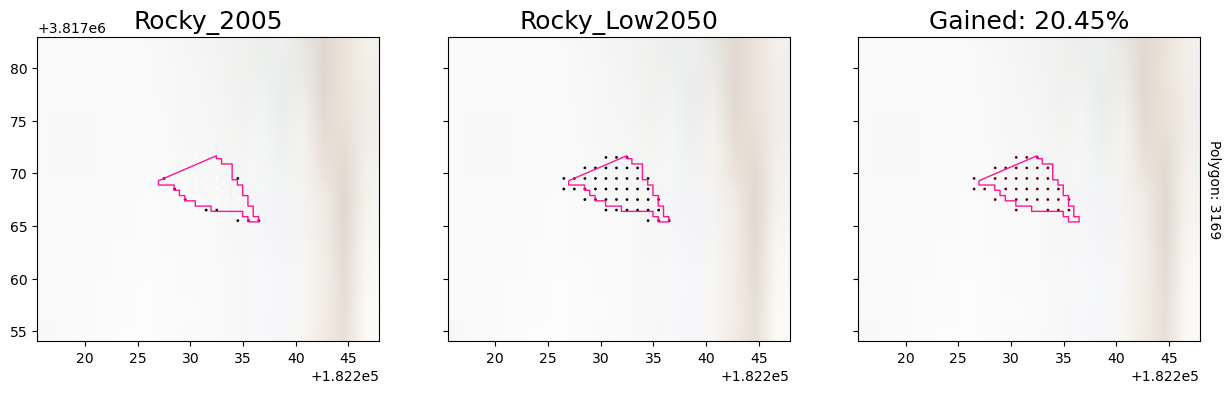

In [151]:
gdf_cari_poly = gdf_rocky_coned.loc[[ix_gain]].to_crs(gdf_tile_poly_gain.crs)
fig, axes = plt.subplots(figsize=(15, 12), ncols=3, sharey=True)
for ax, col in zip(axes, f'Rocky_2005 Rocky_{scen0} Rocky_Gained'.split()):
    gdf_cari_poly.buffer(10).plot(ax=ax, alpha=0)
    cmap = 'Reds_r' if col == 'Rocky_Gained' else 'binary_r'
    
    gdf_tile_poly_gain.plot(ax=ax, column=col, cmap=cmap, markersize=1, legend=False, categorical=True)
    gdf_cari_poly.plot(ax=ax, **sty_cari)
    cx.add_basemap(ax=ax, crs=gdf_tile_poly_gain.crs, source=cxbasemap_t, attribution=False, zoom=16)
    ax.set_title(col, fontsize=TFS-2)

    # pt = point_lost if col == 'Rocky_Gained' else point
    # ax.legend(handles=[rect_beach, pt], loc='upper right')
    
pct_lost = 100*(gdf_tile_poly_gain['Rocky_Gained'].mean())
ax.set_title(f'Gained: {pct_lost:.2f}%', fontsize=TFS-2)
ax.yaxis.set_label_position("right")
print (f'Tile {tile_stem}')
# ax.set_ylabel(f'Tile: {tile_stem}', rotation=270, labelpad=15, fontsize=10);
ax.set_ylabel(f'Polygon: {ix_gain}', rotation=270, labelpad=15, fontsize=10);

## Lost

In [152]:
ix_lost = 9151
gdf_poly_lost = gdf0[gdf0['poly_ix'] == ix_lost]

## get the tile data with the individual point lost/gained
gdf_tile_poly_lost = gdf_tile0[gdf_tile0['poly_ix'] == ix_lost].copy().rename(columns={'MLLW': 'Rocky_2005', f'{scen0}_MLLW': f'Rocky_{scen0}'})
gdf_tile_poly_lost['Rocky_Lost'] = gdf_tile_poly_lost[f'Rocky_2005'] - gdf_tile_poly_lost[f'Rocky_{scen0}'] # 1 if lost, 0 if kept
mu_lost = 100*gdf_tile_poly_lost['Rocky_Lost'].mean()
gdf_tile_poly_lost['Rocky_Lost'] = gdf_tile_poly_lost['Rocky_Lost'].where(gdf_tile_poly_lost['Rocky_Lost'] > 0, np.nan) # to show only where we lost
assert mu_lost == 100*gdf_poly_lost[f'{scen0}_MLLW'].mean(), 'Means should agree.'

Tile Southern_California_Topobathy_DEM_1m_A_01_rocky_Low2050
Based on MLLW
White is beach, black is not
Lost panel shows only where lost


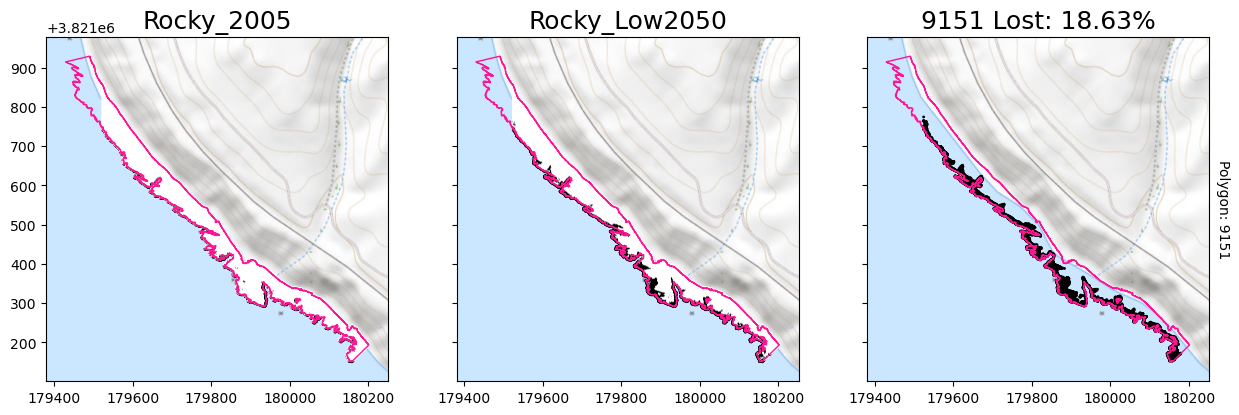

In [153]:
gdf_cari_poly = gdf_rocky_coned.loc[[ix_lost]].to_crs(gdf_tile_poly_lost.crs)
fig, axes = plt.subplots(figsize=(15, 12), ncols=3, sharey=True)
for ax, col in zip(axes, f'Rocky_2005 Rocky_{scen0} Rocky_Lost'.split()):
    gdf_cari_poly.buffer(10).plot(ax=ax, alpha=0)
    # cmap = 'Reds_r' if col == 'Rocky_Gained' else 'binary_r'
    cmap = 'binary_r'
    
    gdf_tile_poly_lost.plot(ax=ax, column=col, cmap=cmap, markersize=1, legend=False, categorical=True)
    gdf_cari_poly.plot(ax=ax, **sty_cari)
    cx.add_basemap(ax=ax, crs=gdf_tile_poly_lost.crs, source=cxbasemap_t, attribution=False, zoom=16)
    ax.set_title(col, fontsize=TFS-2)

ax.set_title(f'{ix_lost} Lost: {mu_lost:.2f}%', fontsize=TFS-2)
ax.yaxis.set_label_position("right")
print (f'Tile {tile_stem}')
# ax.set_ylabel(f'Tile: {tile_stem}', rotation=270, labelpad=15, fontsize=10);
ax.set_ylabel(f'Polygon: {ix_lost}', rotation=270, labelpad=15, fontsize=10);
print ('Based on MLLW')
print ('White is beach, black is not')
print ('Lost panel shows only where lost')

## Lost and Gained

In [154]:
ix_both = 59
gdf_poly_both = gdf0[gdf0['poly_ix'] == ix_both]
tile_stem = gdf_poly_both.tile.unique().item()

## get the tile data with the individual point lost/gained
gdf_tile1 = gpd.read_file(path_dems_all / f'{tile_stem}.GeoJSON').rename(columns={'MAH': 'MAH_CONED', f'{scen0}_MAH': f'{scen0}_MAH_CONED'})
gdf_tile1 = gdf_tile1.copy()
gdf_tile1['Rocky_2005'] =  np.where((gdf_tile1['MAH_CONED'] + gdf_tile1['MAH_ENSO']) > 0, 1, 0) 
gdf_tile1[f'Rocky_{scen0}'] =  np.where((gdf_tile1[f'{scen0}_MAH_CONED'] + gdf_tile1[f'{scen0}_MAH_ENSO']) > 0, 1, 0) 
gdf_tile1['Rocky_Gained'] = gdf_tile1[f'Rocky_{scen0}'] - gdf_tile1[f'Rocky_2005']
gdf_tile1['Rocky_Lost'] = gdf_tile1[f'MLLW'] - gdf_tile1[f'{scen0}_MLLW'] # 1 if lost, 0 if kept

## same as in combine; combine the two columns to show GAIN before and after SLR 
gdf_tile1_poly = gdf_tile1.groupby('poly_ix').get_group(ix_both).copy()
mu_gain, mu_lost = 100*gdf_tile1_poly['Rocky_Gained'].mean(), 100*gdf_tile1_poly['Rocky_Lost'].mean()
assert mu_gain == -100*gdf_poly_both[f'{scen0}_MAH'].mean(), 'Means should agree.'
assert mu_lost == 100*gdf_poly_both[f'{scen0}_MLLW'].mean(), 'Means should agree.'

gdf_tile1_poly['Rocky_Lost'] = gdf_tile1_poly['Rocky_Lost'].where(gdf_tile1_poly['Rocky_Lost'] > 0, np.nan) # to show only where we lost
gdf_tile1_poly['Rocky_Gained'] = gdf_tile1_poly['Rocky_Gained'].where(gdf_tile1_poly['Rocky_Gained'] > 0, np.nan) # to show only where gained

Tile Southern_California_Topobathy_DEM_1m_E_10_rocky_Low2050


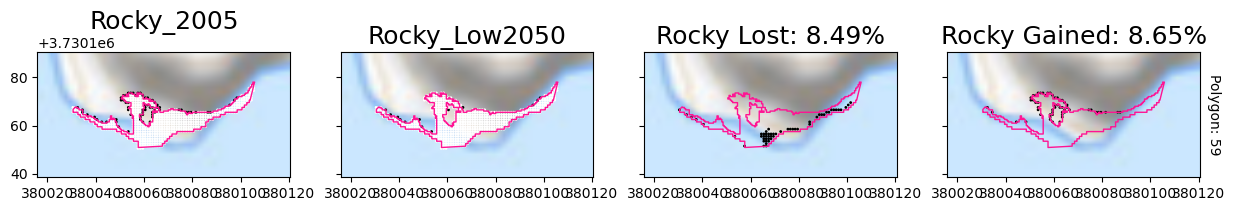

In [155]:
gdf_cari_poly = gdf_rocky_coned.loc[[ix_both]].to_crs(gdf_tile1_poly.crs)
fig, axes = plt.subplots(figsize=(15, 12), ncols=4, sharey=True)
for ax, col in zip(axes, f'Rocky_2005 Rocky_{scen0} Rocky_Lost Rocky_Gained'.split()):
    gdf_cari_poly.buffer(10).plot(ax=ax, alpha=0)
    gdf_tile1_poly.plot(ax=ax, column=col, cmap='binary_r', markersize=1, legend=False, categorical=True)
    gdf_cari_poly.plot(ax=ax, **sty_cari)
    cx.add_basemap(ax=ax, crs=gdf_tile_poly.crs, source=cxbasemap_t, attribution=False, zoom=16)
    ax.set_title(col, fontsize=TFS-2)

    # pt = point_lost if col == 'Rocky_Gained' else point
    # ax.legend(handles=[rect_beach, pt], loc='upper right')
    
axes[2].set_title(f'Rocky Lost: {mu_lost:.2f}%', fontsize=TFS-2)
axes[3].set_title(f'Rocky Gained: {mu_gain:.2f}%', fontsize=TFS-2)
ax.yaxis.set_label_position("right")
print (f'Tile {tile_stem}')
# ax.set_ylabel(f'Tile: {tile_stem}', rotation=270, labelpad=15, fontsize=10);
ax.set_ylabel(f'Polygon: {ix_both}', rotation=270, labelpad=15, fontsize=10);

# Overall Bar Plots
-- not going to be right because we're taking mean percent lost which don't account for area of polygons

## Stacked

In [43]:
lst_beach_res = []
for yeari in years:
    for sceni in scens:
        sy = f'{sceni}{yeari}'
        print (sy)
        lst_dfs  = []
        lst_paths = sorted(list(path_res.glob(f'*_beach_{sy}.csv')))
        
        for path in lst_paths:
            reg, hab, sce =  path.stem.split('_')
            dfi = pd.read_csv(path, index_col=0)
            dfi['reg'] = reg
            # 1 means we lost it
            pct_lost = 100*dfi[f'{sy}_MLLW'].mean()
            lst_dfs.append(dfi)
            
        df_m = pd.concat(lst_dfs).drop_duplicates('geometry') 
        # print (f'Number of points: {df_m.groupby('reg').count()['poly_ix']}')
        ser_mu  = df_m.groupby('reg')[f'{sy}_MLLW'].mean()
        mu_reg = ser_mu.mean() # will be slightly differnt than total, but check
        ser_mu['Total'] = df_m[f'{sy}_MLLW'].mean()
        ser_mu['Resid'] = ser_mu['Total'] - mu_reg
        # convert to % 
        ser_mu *= 100
        lst_beach_res.append(ser_mu.rename(f'{sy}'))

Low2050
IntLow2050
Int2050
IntHigh2050
High2050
Low2100
IntLow2100
Int2100
IntHigh2100
High2100


In [44]:
# sum over the two columns (axis=1) of MLLW and MAH and take the mean, as long as 1 is lost for both. 

In [45]:
lst_rocky_res = []
lst_df_temps = []
for yeari in years:
    for j, sceni in enumerate(scens):
        sy = f'{sceni}{yeari}'
        print (sy)
        lst_dfs  = []
        lst_paths = sorted(list(path_res.glob(f'*_rocky_{sceni}{yeari}.csv')))
        
        for path in lst_paths:
            reg, hab, sce =  path.stem.split('_')
            # if reg == 'Central':
            #     continue
            dfi = pd.read_csv(path, index_col=0)
            dfi['reg'] = reg
            # 1 means we lost it
            pct_lost = 100*dfi[f'{sy}_MLLW'].mean()
            lst_dfs.append(dfi)
            if reg == 'Central':
                lst_df_temps.append(dfi)
            
        df_m = pd.concat(lst_dfs).drop_duplicates('geometry') 
        # print (f'Number of points: {df_m.groupby('reg').count()['poly_ix']}')
        ser_mu  = df_m.groupby('reg')[f'{sy}_MLLW'].mean()
        mu_reg = ser_mu.mean() # will be slightly differnt than total, but check
        # print (f'{sceni} {yeari}: {100*mu_reg:.2f}')
        ser_mu['Total'] = df_m[f'{sy}_MLLW'].mean()
        ser_mu['Resid'] = ser_mu['Total'] - mu_reg
        # convert to % 
        ser_mu_g = df_m.groupby('reg')[f'{sy}_MAH'].mean()
        mu_reg_gain = ser_mu_g.mean()
        ser_mu_g['Total'] = df_m[f'{sy}_MAH'].mean()
        ser_mu_g['Resid'] = ser_mu_g['Total'] - mu_reg_gain
        df_mu = pd.concat([ser_mu, ser_mu_g], axis=1) * 100
        df_mu[sy] = df_mu[f'{sy}_MLLW'] + df_mu[f'{sy}_MAH']
        lst_rocky_res.append(df_mu)

Low2050
IntLow2050
Int2050
IntHigh2050
High2050
Low2100
IntLow2100
Int2100
IntHigh2100
High2100


In [49]:
## prep datafarmes for regional plots
lst_df_plot = []
for year in years:
    for lst in [lst_beach_res, lst_rocky_res]: 
        ## old beaches
        # df1 = pd.concat(lst_beach_res, axis=1).filter(like=year)
        # df1.columns = df1.columns.str.replace(year, '')
        df1 = pd.concat(lst_rocky_res, axis=1).filter(like=year).filter(like='MLLW')
        df1.columns = df1.columns.str.replace(f'{year}_MLLW', '')
        
        df1.drop('Total Resid'.split(), inplace=True)
        df1 = df1.loc['South Central North'.split()] # sort 
        lst_df_plot.append(df1.reset_index().melt(id_vars='reg', var_name='scenario', value_name='% Lost'))

df_beach_2050, df_beach_2100 = lst_df_plot[:2]
df_rocky_2050, df_rocky_2100 = lst_df_plot[2:]

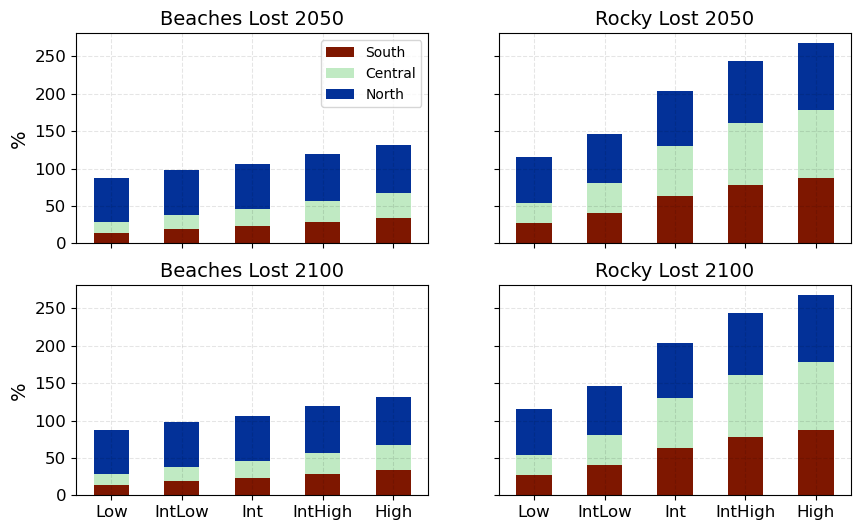

In [50]:
## plot the totals
df_beach_2050_p = df_beach_2050.pivot(index='scenario', columns='reg', values='% Lost').sort_values('Central')['South Central North'.split()]
df_beach_2100_p = df_beach_2100.pivot(index='scenario', columns='reg', values='% Lost').sort_values('Central')['South Central North'.split()]

df_rocky_2050_p = df_rocky_2050.pivot(index='scenario', columns='reg', values='% Lost').sort_values('Central')['South Central North'.split()]
df_rocky_2100_p = df_rocky_2100.pivot(index='scenario', columns='reg', values='% Lost').sort_values('Central')['South Central North'.split()]

fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2, sharex='col', sharey=True)
df_beach_2050_p.plot(kind='bar', stacked=True, ax=axes[0, 0], cmap='cmc.roma')
df_beach_2100_p.plot(kind='bar', stacked=True, ax=axes[1, 0], cmap='cmc.roma')
df_rocky_2050_p.plot(kind='bar', stacked=True, ax=axes[0, 1], cmap='cmc.roma')
df_rocky_2100_p.plot(kind='bar', stacked=True, ax=axes[1, 1], cmap='cmc.roma')

axes[0, 0].set_title('Beaches Lost 2050', fontsize=14)
axes[1, 0].set_title('Beaches Lost 2100', fontsize=14)
axes[0, 1].set_title('Rocky Lost 2050', fontsize=14)
axes[1, 1].set_title('Rocky Lost 2100', fontsize=14)

for ax in axes.ravel():
    ax.grid(color='k', alpha=0.1, linestyle='--')
    ax.set_ylabel('%', fontsize=14)
    ax.tick_params(rotation=0, labelsize=12)
    ax.legend().set_visible(False)
    ax.set_xlabel('')
    
axes[0, 0].legend().set_visible(True)
axes[0,0].legend().set_title('')


## Total

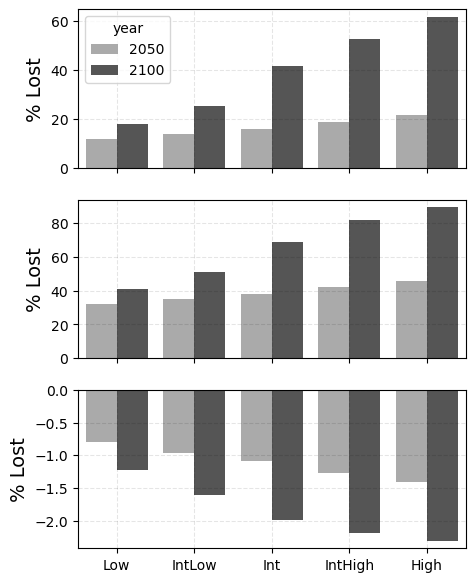

In [84]:
sty = dict(x='scenario', y='Total', hue='year', errorbar='sd', palette='binary')
df_beach = pd.DataFrame(pd.concat(lst_beach_res, axis=1).loc['Total'])
df_beach['scenario'] = df_beach.index.str[:-4]
df_beach['year'] = df_beach.index.str[-4:]

df_rocky = pd.DataFrame(pd.concat(lst_rocky_res, axis=1).loc['Total'].filter(like='MLLW'))
df_rocky.index = df_rocky.index.str.rstrip('_MLLW')
df_rocky['scenario'] = df_rocky.index.str[:-4]
df_rocky['year'] = df_rocky.index.str[-4:]

df_rocky_gain = pd.DataFrame(pd.concat(lst_rocky_res, axis=1).loc['Total'].filter(like='MAH'))
df_rocky_gain.index = df_rocky_gain.index.str.rstrip('_MAH')
df_rocky_gain['scenario'] = df_rocky_gain.index.str[:-4]
df_rocky_gain['year'] = df_rocky_gain.index.str[-4:]

fig, axes = plt.subplots(figsize=(5, 7), nrows=3, sharex=True)
for i, df in enumerate([df_beach, df_rocky, df_rocky_gain]):
    bp = sns.barplot(data=df, ax=axes[i], **sty)
    axes[i].grid(color='k', linestyle='--', alpha=0.1)
    axes[i].set_ylabel('% Lost', fontsize=YFS-2)
    if i > 0:
        bp.legend().set_visible(False)

axes[i].set_xlabel('');

# Check Polygon Estimates

In [158]:
## get the files with the pct lost/gained for each polygon
hab1, year1, scen1 = 'rocky', 2050, 'Low'
src1 = path_res / f'{hab1}_polygons_lost_{year1}.GeoJSON' 
gdf_polys = gpd.read_file(src1)
gdf_scen = gdf_polys[gdf_polys['scenario'] == scen1.title()]
gdf_scen.head()

,cari_ix,pct_lost,pct_gain,pct_total,scenario,year,region,geometry
0,1,24.434389,0.904977,-23.529412,Low,2050,Central,"MULTIPOLYGON (((-121.92687 36.45361, -121.9268..."
1,10,16.972477,1.834862,-15.137615,Low,2050,Central,"MULTIPOLYGON (((-121.92712 36.45354, -121.9271..."
2,14,37.558685,-0.000000,-37.558685,Low,2050,Central,"MULTIPOLYGON (((-121.92632 36.45377, -121.9263..."
3,15,33.066667,1.333333,-31.733333,Low,2050,Central,"MULTIPOLYGON (((-121.92618 36.45378, -121.9261..."
4,16,4.477612,2.611940,-1.865672,Low,2050,Central,"MULTIPOLYGON (((-121.92578 36.45386, -121.9257..."


## Check out high percent lost

78 rocky polygons lost more than 90% in 2050 Low


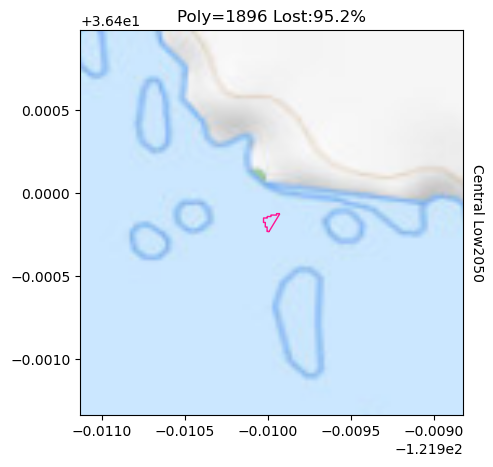

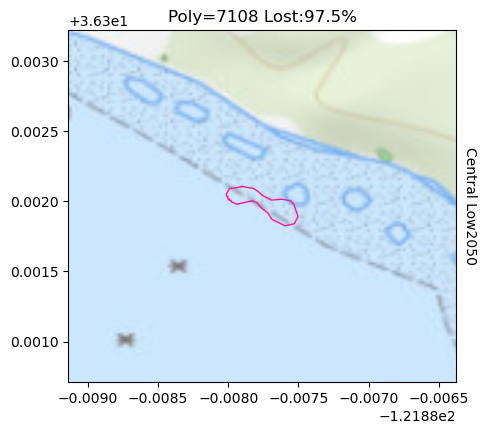

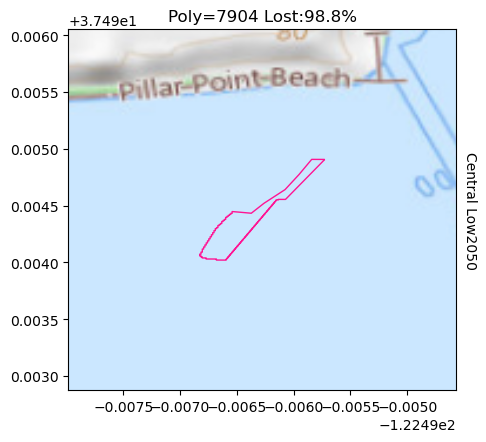

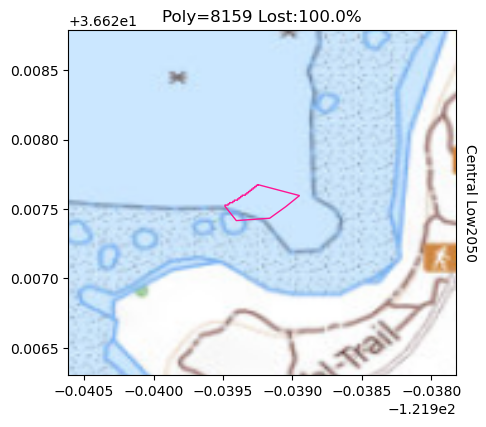

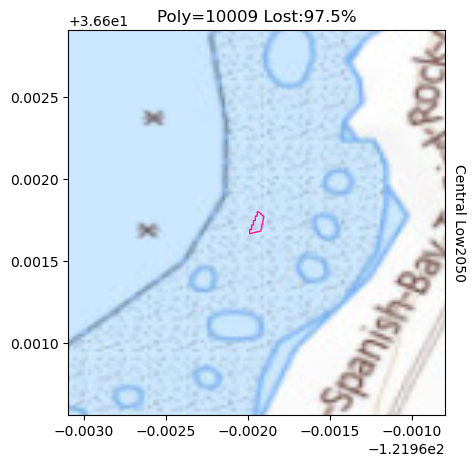

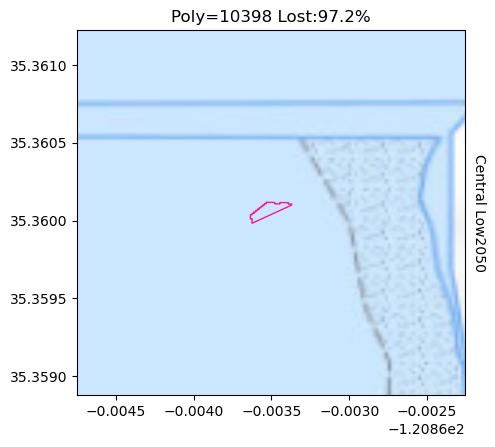

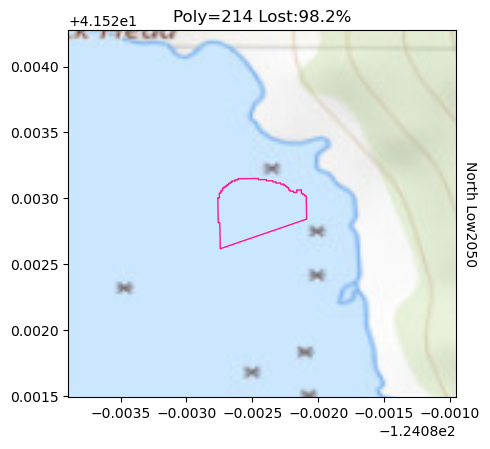

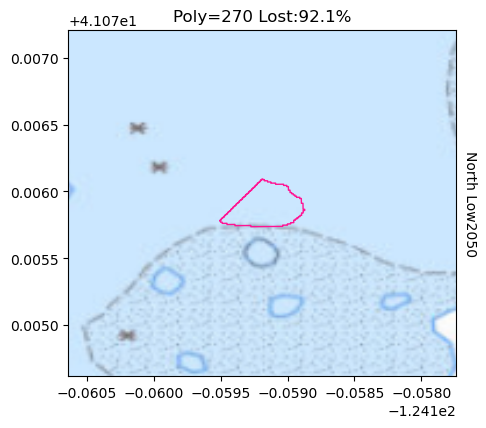

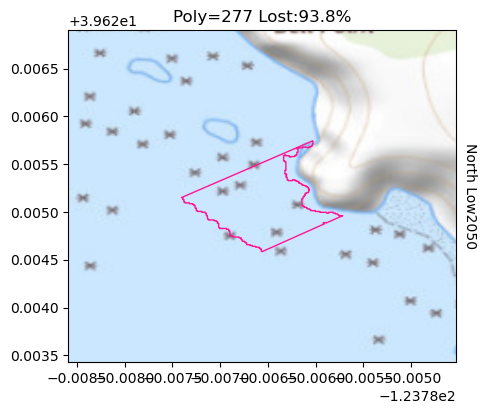

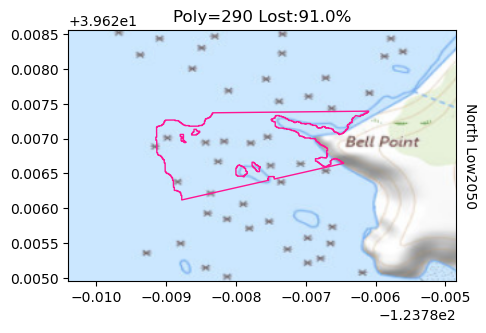

In [169]:
thresh_lost = 90
gdf_scen_lost = gdf_scen[gdf_scen['pct_lost'] >= thresh_lost]
print (f'{gdf_scen_lost.shape[0]} {hab1} polygons lost more than {thresh_lost}% in {year1} {scen1}')
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    ## plot some of them 
    for i in range(10):
        fig, axes = plt.subplots(figsize=(5,5))
        gdfi = gdf_scen_lost.iloc[[i]]
        gdfi.buffer(1e-3).plot(ax=axes, alpha=0)
        gdfi.plot(ax=axes, **sty_cari)
        cx.add_basemap(ax=axes, crs=gdfi.crs, source=cxbasemap_t, attribution=False, zoom=16)
        axes.set_title(f'Poly={gdfi["cari_ix"].item()} Lost:{gdfi['pct_lost'].item():.1f}%')
        axes.yaxis.set_label_position("right")
        axes.set_ylabel(f'{gdfi["region"].item()} {gdfi["scenario"].item()}{gdfi["year"].item()}', rotation=270, labelpad=15, fontsize=10);

## Check out high percent gain

170 rocky polygons gain more than 10% in 2050 Low


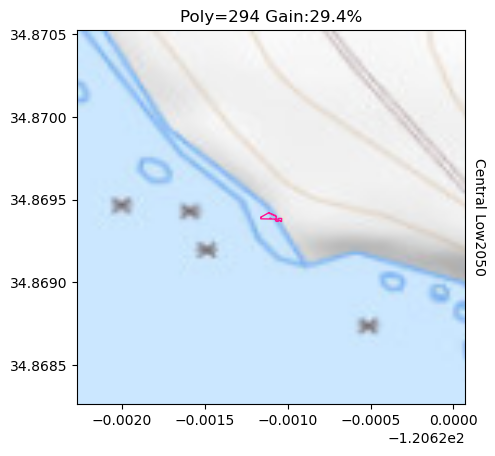

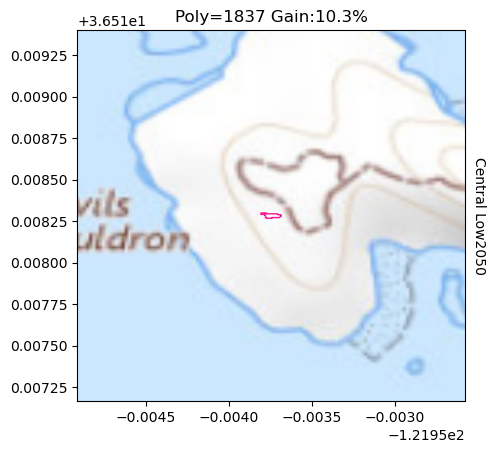

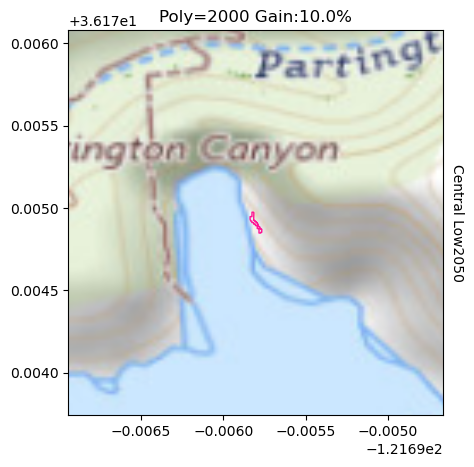

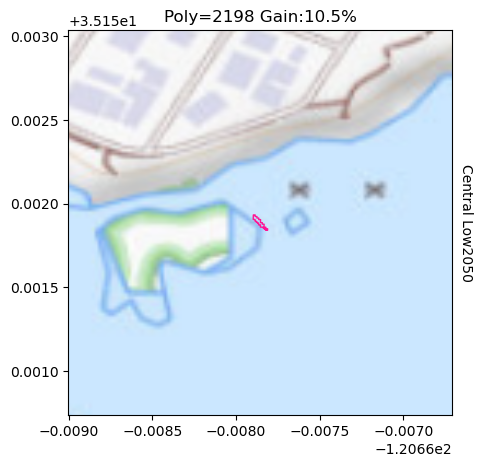

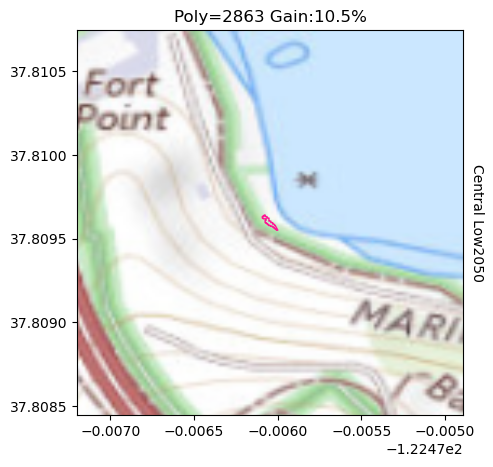

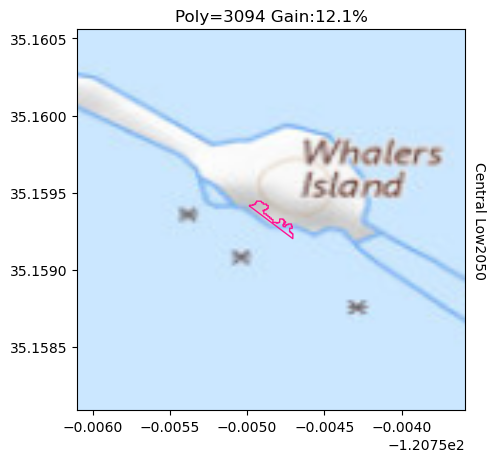

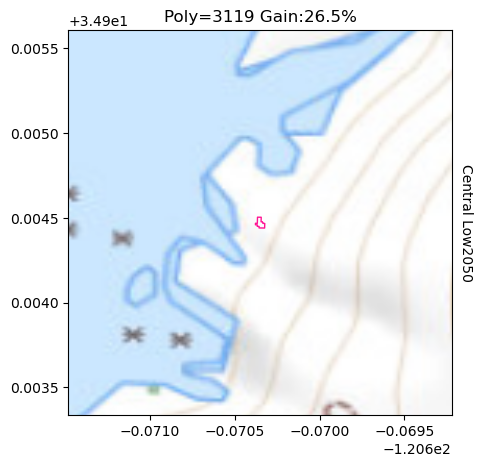

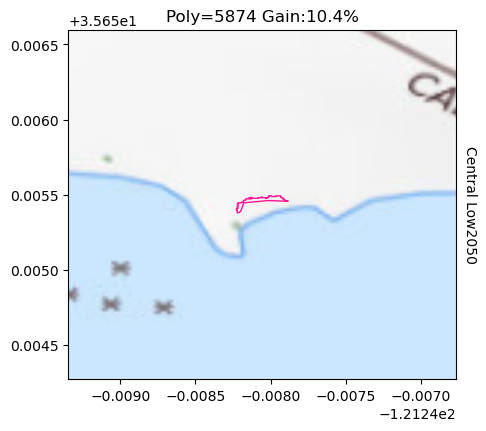

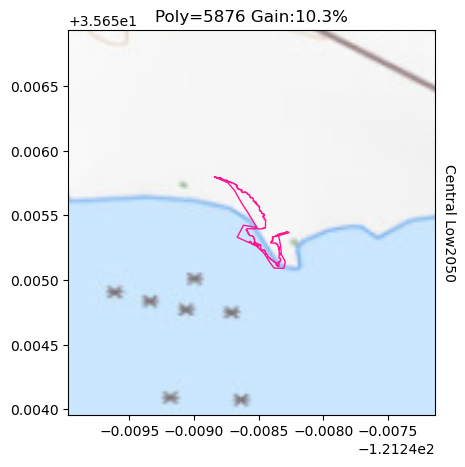

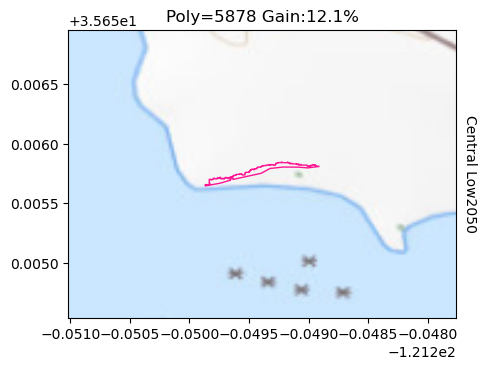

In [170]:
thresh_gain = 20
gdf_scen_gain = gdf_scen[gdf_scen['pct_gain'] >= thresh_gain]
print (f'{gdf_scen_gain.shape[0]} {hab1} polygons gain more than {thresh_gain}% in {year1} {scen1}')
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    ## plot some of them 
    for i in range(10):
        fig, axes = plt.subplots(figsize=(5,5))
        gdfi = gdf_scen_gain.iloc[[i]]
        gdfi.buffer(1e-3).plot(ax=axes, alpha=0)
        gdfi.plot(ax=axes, **sty_cari)
        cx.add_basemap(ax=axes, crs=gdfi.crs, source=cxbasemap_t, attribution=False, zoom=16)
        axes.set_title(f'Poly={gdfi["cari_ix"].item()} Gain:{gdfi['pct_gain'].item():.1f}%')
        axes.yaxis.set_label_position("right")
        axes.set_ylabel(f'{gdfi["region"].item()} {gdfi["scenario"].item()}{gdfi["year"].item()}', rotation=270, labelpad=15, fontsize=10);

# These 2 not implemented

## Cut by % lost

In [54]:
def prep_df_plot(df_low_in):
    df_low_reg_mllw = pd.DataFrame(df_low_in.groupby('region')[f'{scen}_MLLW'].mean().rename('MLLW')).T
    df_low_reg_mllw['Total'] = df_low_in[f'{scen}_MLLW'].mean().T
    df_low_reg_mllw.columns.name 
    
    df_low_reg_mah = pd.DataFrame(df_low_in.groupby('region')[f'{scen}_MAH'].mean().rename('MAH')).T
    df_low_reg_mah['Total'] = df_low_in[f'{scen}_MAH'].mean()
    df_low_reg_mah.columns.name  = ''
    
    df_low_out = pd.concat([df_low_reg_mllw, df_low_reg_mah]).T.rename_axis('region').reset_index()
    df_low_melt = df_low_out.melt(id_vars='region', var_name='datum', value_name='pct')
    df_low_melt['pct'] *=100
    return df_low_melt


In [ ]:
df_low, ser_pcts_low = cut_polys(df_all, gdf_cari, pct_lost_min=-80)[:2]
df_low_melt = prep_df_plot(df_low)

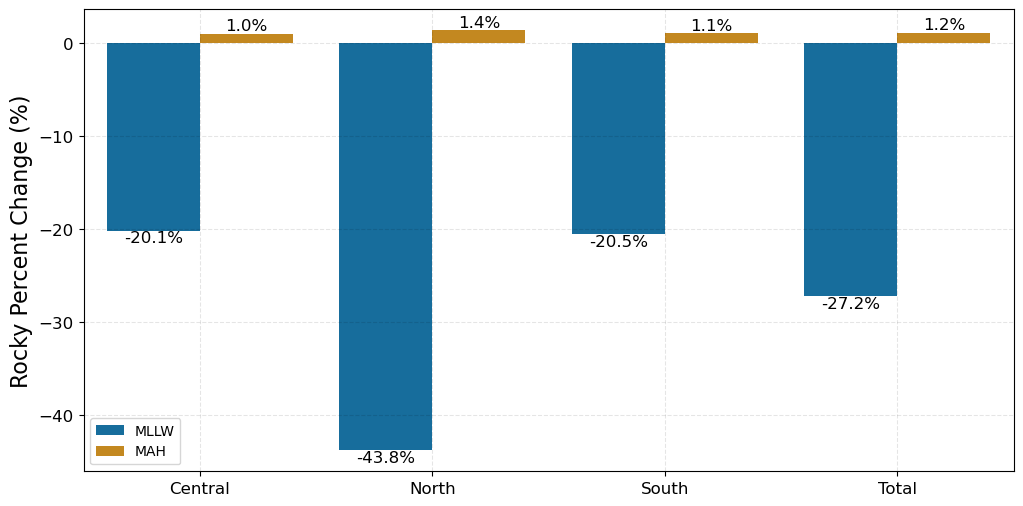

In [66]:
fig, axes = plt.subplots(figsize=(12, 6))
bp = sns.barplot(data=df_low_melt, x='region', y='pct', hue='datum', palette='colorblind', ax=axes)
bp.legend().set_title('')
axes.set_ylabel('Rocky Percent Change (%)', fontsize=XFS)
axes.set_xlabel('')
axes.grid(color='k', alpha=0.1, linestyle='--')
axes.tick_params(axis='both', labelsize=XFS-4)  
axes.bar_label(axes.containers[0], fmt="{:.1f}%".format, fontsize=XFS-4);
axes.bar_label(axes.containers[1], fmt="{:.1f}%".format, fontsize=XFS-4);

## Cut by Area

In [ ]:
df_big1, ser_pcts_big1 = cut_polys(df_all, gdf_beach, area_min=1)[:2]
plot_bars(ser_pcts_big1);

In [ ]:
df_big2, ser_pcts_big2 = cut_polys(df_all, gdf_beach, area_min=10000)[:2]
plot_bars(ser_pcts_big2);

In [ ]:
## plot the histogram to figure out where to cut; actually just use quantiles
lst_poly_area = cut_polys(df_all, gdf_beach, pct_lost_max=100, area_min=0)[2]
fig, axes = plt.subplots(figsize=(10, 4))
sns.histplot(lst_poly_area, kde=False, color='dimgray', ax=axes)
axes.set_xlim([0, 50000])
axes.set_xlabel('Area (m$^2$)')
print (f'5%: {np.nanquantile(lst_poly_area, 0.05):.2f}, 95%: {np.nanquantile(lst_poly_area, 0.95):.2f}')
print (f'5%: {np.nanmean(lst_poly_area):.2f} +/- {np.nanstd(lst_poly_area):.2f} (\n\t1*lower_bound={np.nanmean(lst_poly_area)-np.nanstd(lst_poly_area):.2f}')

# Check on Running Results

In [74]:
print ('\n---CARI---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_cari = sorted([f.stem for f in list(path_res.glob('*0.csv'))])
for f in existing_cari:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---CARI---



2050  2100
Region  Habit Scenario            
South   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
Central rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
North   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done

In [75]:
print ('\n---CARI+VLM ---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_cari_vlm = sorted([f.stem for f in list(path_res.glob('*vlm.csv'))])
for f in existing_cari_vlm:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---CARI+VLM ---



2050  2100
Region  Habit Scenario            
South   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
Central rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
North   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done

In [78]:
print ('\n---S2---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_s2 = sorted([f.stem for f in list(path_res.glob('*0_s2.csv'))])
for f in existing_s2:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---S2---



2050     2100
Region  Habit Scenario                  
South   rocky Low          Done  MISSING
              IntLow       Done  MISSING
              Int          Done  MISSING
              IntHigh      Done  MISSING
              High         Done  MISSING
        beach Low          Done     Done
              IntLow       Done     Done
              Int          Done     Done
              IntHigh      Done  MISSING
              High         Done  MISSING
Central rocky Low          Done     Done
              IntLow       Done     Done
              Int          Done     Done
              IntHigh      Done  MISSING
              High      MISSING  MISSING
        beach Low          Done     Done
              IntLow    MISSING     Done
              Int       MISSING     Done
              IntHigh   MISSING     Done
              High      MISSING     Done
North   rocky Low          Done     Done
              IntLow       Done     Done
              Int          Done     Done
              IntHigh      Done     Done
              High         Done     Done
        beach Low          Done     Done
              IntLow       Done     Done
              Int          Done     Done
              IntHigh      Done     Done
              High         Done     Done

In [77]:
print ('\n---S2 VLM---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_s2_vlm = sorted([f.stem for f in list(path_res.glob('*vlm_s2.csv'))])
for f in existing_s2_vlm:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---S2 VLM---



2050     2100
Region  Habit Scenario               
South   rocky Low       Done     Done
              IntLow    Done     Done
              Int       Done  MISSING
              IntHigh   Done  MISSING
              High      Done  MISSING
        beach Low       Done     Done
              IntLow    Done     Done
              Int       Done     Done
              IntHigh   Done     Done
              High      Done     Done
Central rocky Low       Done     Done
              IntLow    Done     Done
              Int       Done  MISSING
              IntHigh   Done  MISSING
              High      Done  MISSING
        beach Low       Done     Done
              IntLow    Done     Done
              Int       Done     Done
              IntHigh   Done     Done
              High      Done     Done
North   rocky Low       Done     Done
              IntLow    Done     Done
              Int       Done     Done
              IntHigh   Done     Done
              High      Done     Done
        beach Low       Done     Done
              IntLow    Done     Done
              Int       Done     Done
              IntHigh   Done     Done
              High      Done     Done